# Get Libraries

In [1]:
import json
import pandas as pd
import requests
import datetime
from binance import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
from functools import reduce
binance_client = Client()

In [2]:
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2022,10,10)

# Create functions

In [3]:
# Binance Spot
def get_binance(symbol, interval, startTime, endTime, limit):
    url = "https://api.binance.com/api/v3/klines"

    startTime = str(int(startTime.timestamp() * 1000))
    endTime = str(int(endTime.timestamp() * 1000))


    req_params = {"symbol" : symbol, "interval" : interval, "startTime" : startTime, "endTime" : endTime, "limit" : limit}

    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text))
    if (len(df) == 0):
        return None
    
    df = df.iloc[:, 0:6]
    df.columns = ["datetime", "open", "high", "low", "close_spot_bin", "volume_spot_bin"]
    df["date"] = [datetime.datetime.fromtimestamp(x / 1000.0) for x in df["datetime"]]
    df['Date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index(df["Date"])
    df = df.drop(["datetime","open", "high", "low", "Date", "date", "volume_spot_bin"],axis = 1)
    df["close_spot_bin"] = [float(x) for x in df["close_spot_bin"]]

    
    return df

In [4]:
def get_stock(ticker):
    data = web.DataReader(f"{ticker}","yahoo",start,end)
    data[f'{ticker}'] = data["Close"]
    data = data[[f'{ticker}']] 
    #print(data.head())
    return data 

In [5]:
def combine_stocks(tickers):
    data_frames = []
    for i in tickers:
        data_frames.append(get_stock(i))
        
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
    return df_merged

# Creating portfolios

## Portfolio 1

In [6]:
df_binance_spot = get_binance(symbol = "ETHUSDT", interval = "1d",
                 startTime = start,
                 endTime = end, limit = "1000")


df = df_binance_spot
df = df.drop(["close_spot_bin"],axis=1)

In [7]:
_names = ["BTC", "ETH", "MATIC", "TRX", "BNB", "XRP", "DOT", "ADA", "AVAX", "DOGE"]
_crypto_tickers = []
for x in _names:
    _crypto_tickers.append(x+"USDT")

In [8]:
for x in _crypto_tickers:
    data = get_binance(symbol = x, interval = "1d",
                 startTime = start,
                 endTime = end,
                       limit = "1000")
    data.columns= [x]
    df = df.merge(data, on = ["Date"], how = 'left')

In [9]:
# Equal weights
portfolio = df.mean(axis=1)
# I could use .pct_change() but it is not interesting
_portfolio_returns = [np.log(portfolio[i]/portfolio[i-1]) 
                          for i in range(1, len(portfolio))]
_portfolio_return_list= [0]

for x in _portfolio_returns:
    _portfolio_return_list.append(x)

In [10]:
portfolio = pd.DataFrame(portfolio)
portfolio["returns"] = _portfolio_return_list
portfolio.columns = ["Portfolio_value", "Portfolio_return"]

Text(0.5, 1.0, 'Portfolio value')

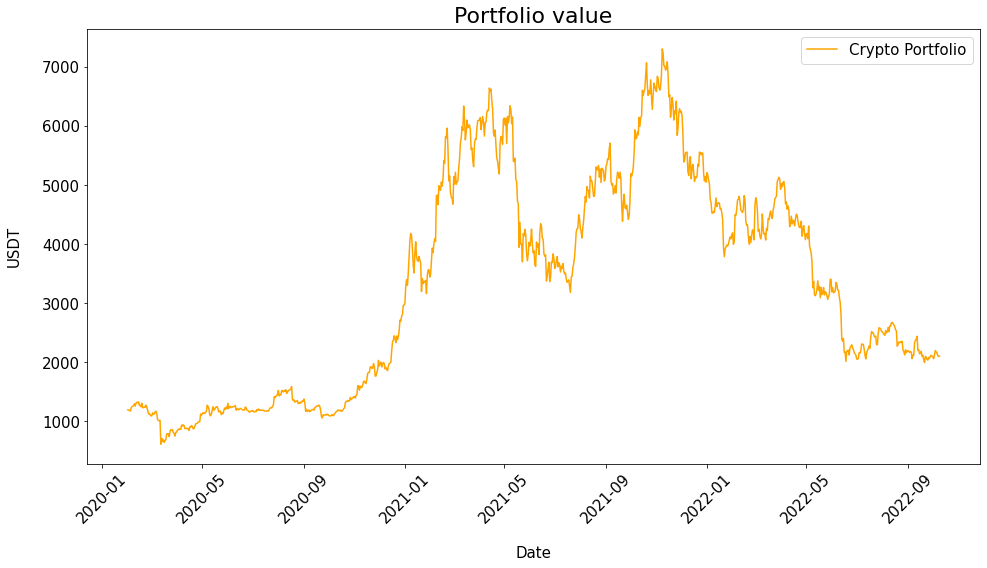

In [11]:
plt.figure(figsize=(16,8))
plt.plot(portfolio["Portfolio_value"], label = "Crypto Portfolio", c = "orange")
plt.legend(fontsize =15)
plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("USDT", fontsize =15, labelpad =20)
plt.title("Portfolio value", fontsize = 22)

Text(0.5, 1.0, 'Portfolio Return')

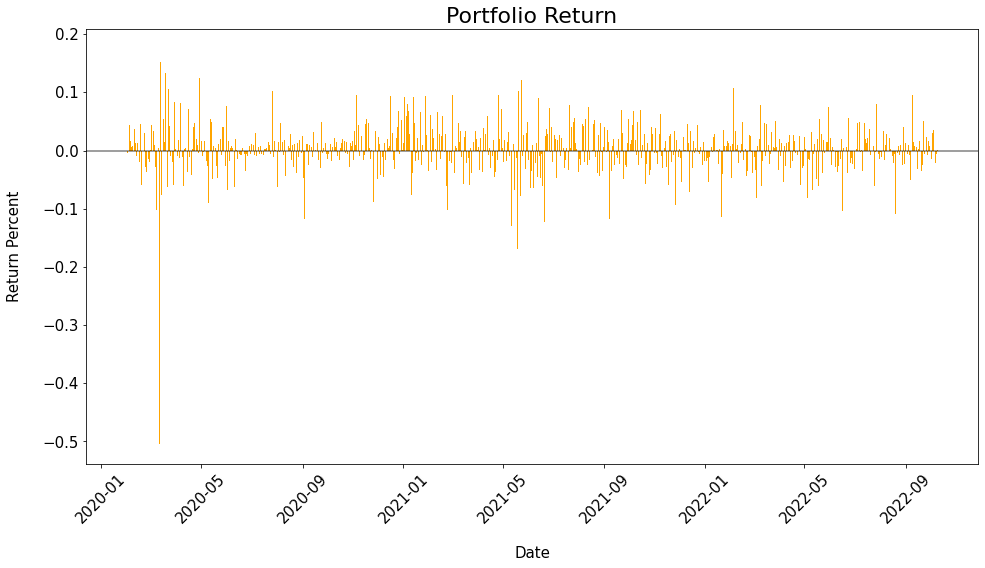

In [12]:
plt.figure(figsize=(16,8))
plt.bar(x =portfolio.index, height = portfolio["Portfolio_return"],
        color = "orange")
plt.axhline(y=0, c = "black", alpha = 0.5)

plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Return Percent", fontsize =15, labelpad =20)
plt.title("Portfolio Return", fontsize = 22)

In [13]:
portfolio["Portfolio_return"].sum(axis=0)

0.5641100133261143

## Portfolio 2

In [14]:
_names = ["AAPL", "AMD", "TSLA", "AMZN", "NVDA", "INTC", "MU", "MSFT", "META", "GOOGL"]
#_stocks = []
#for x in _names:
#    _stocks.append(x+"-USD")
df = combine_stocks(_names)

In [15]:
df.head()

,AAPL,AMD,TSLA,AMZN,NVDA,INTC,MU,MSFT,META,GOOGL
Date,,,,,,,,,,
2020-02-03,77.165001,48.020000,52.000000,100.209999,60.082500,64.419998,53.779999,174.380005,204.190002,74.129997
2020-02-04,79.712502,49.450001,59.137333,102.483498,61.782501,65.459999,55.500000,180.119995,209.830002,72.270500
2020-02-05,80.362503,49.840000,48.980000,101.993500,62.689999,67.339996,56.770000,179.899994,210.110001,72.302498
2020-02-06,81.302498,49.320000,49.930668,102.511497,63.562500,67.089996,58.680000,183.630005,210.850006,73.798500
2020-02-07,80.007500,49.730000,49.871334,103.963997,62.897499,66.019997,56.880001,183.889999,212.330002,73.955498


In [16]:
# Equal weights
portfolio = df.mean(axis=1)

# I could use .pct_change() but it is not interesting
_portfolio_returns = [np.log(portfolio[i]/portfolio[i-1]) 
                          for i in range(1, len(portfolio))]
_portfolio_return_list= [0]

for x in _portfolio_returns:
    _portfolio_return_list.append(x)

In [17]:
portfolio = pd.DataFrame(portfolio)
portfolio["returns"] = _portfolio_return_list
portfolio.columns = ["Portfolio_value", "Portfolio_return"]

Text(0.5, 1.0, 'Portfolio value')

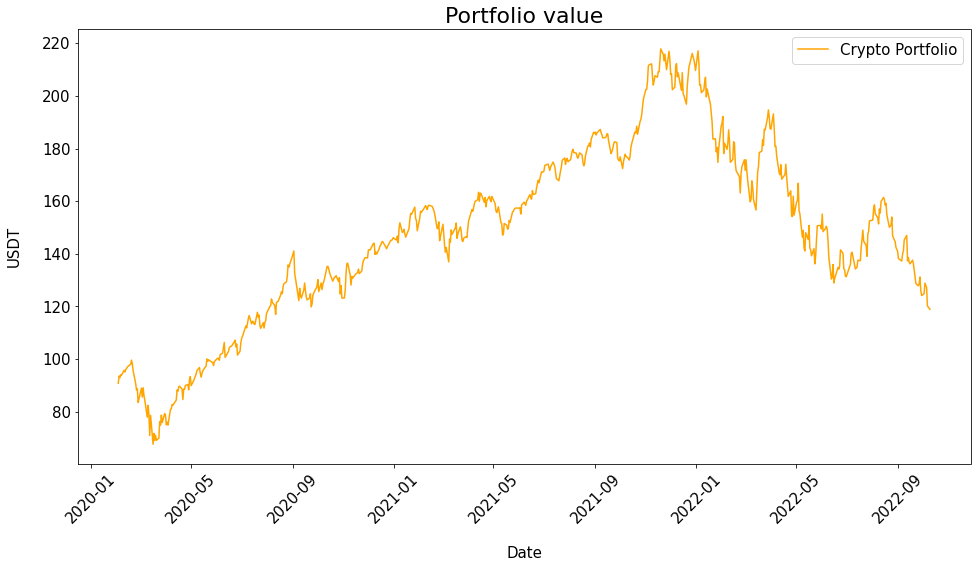

In [18]:
plt.figure(figsize=(16,8))
plt.plot(portfolio["Portfolio_value"], label = "Crypto Portfolio", c = "orange")
plt.legend(fontsize =15)
plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("USDT", fontsize =15, labelpad =20)
plt.title("Portfolio value", fontsize = 22)

Text(0.5, 1.0, 'Portfolio Return')

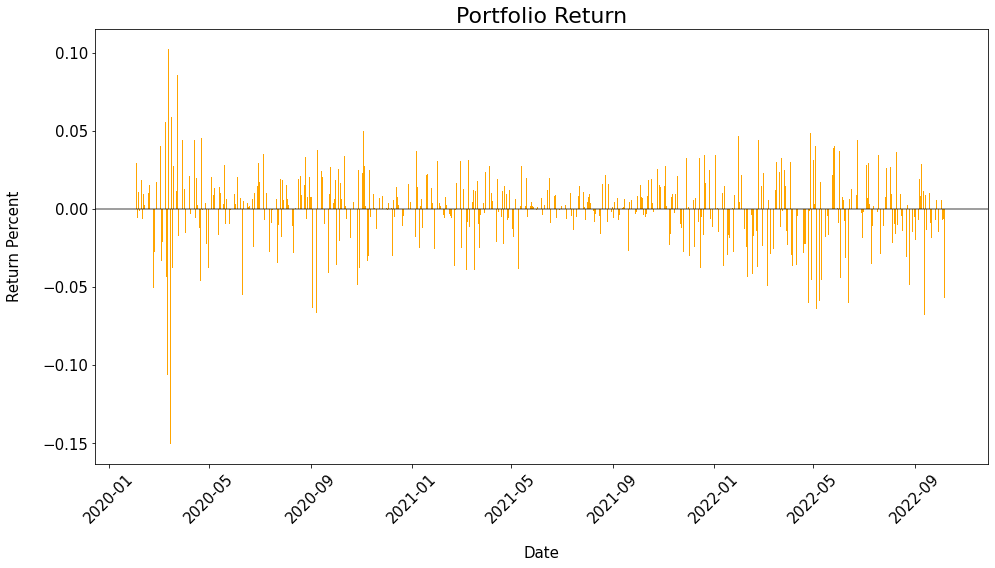

In [19]:
plt.figure(figsize=(16,8))
plt.bar(x =portfolio.index, height = portfolio["Portfolio_return"],
        color = "orange")
plt.axhline(y=0, c = "black", alpha = 0.5)

plt.xticks(rotation=45, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Date", fontsize =15, labelpad =20)
plt.ylabel("Return Percent", fontsize =15, labelpad =20)
plt.title("Portfolio Return", fontsize = 22)

In [20]:
portfolio["Portfolio_return"].sum(axis=0)

0.2692414916143965

Better invest in Crypto

## Portfolio 3

In [21]:
w1 = 0.5
w2 = 0.5
s1 = 0.01
s2 = 0.01
R = 0.3


In [28]:
np.sqrt(w1**2 * s1**2 + w2**2*s2**2 + w1*w2*R*s1*s2 + w2*w1*R*s1*s2) * np.sqrt(5)

0.01802775637731995

In [26]:
import numpy as np

In [29]:
0.02965302046303226 * 200000

5930.6040926064525

In [33]:
200000+(-0.02965302046303226 * 200000)

194069.39590739354